In [ ]:
#@title Package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm , t
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#@title Hyperparameters

GROUP_CLASS = 0
VIDEO = 1
PRIVATE_CLASS = 2
POWERPOINT = 3
EPSILON = 1
BASELINE = 7

In [ ]:
#@title Plot Results
def plot_results(agent_scores,window_size,figure,ax,label,ylabel):

  n_rep, n_episode = np.array(agent_scores).shape
  smoothed_agent_scores = []
  for i in range(n_rep):
    smoothed_agent_scores.append(pd.Series(agent_scores[i]).rolling(window_size , min_periods = 0).mean())

  x_bar = np.mean(np.array(smoothed_agent_scores), axis=0) 
  sigma = np.std(np.array(smoothed_agent_scores), axis=0) 
  SE = sigma / np.sqrt(n_rep)
  interval =  1 - 0.005
  if n_rep < 30:
      t_statistic = t.interval(interval, df = n_rep - 1)[1]
      ME = t_statistic * SE
  else:
      z_statistic = norm.interval(interval)[1]
      ME = z_statistic * SE        

  ax.plot(range(0,n_episode), x_bar , label = label)
  if n_rep >= 2:
      ax.fill_between(range(0,n_episode), (x_bar - ME), (x_bar + ME), alpha=0.05)
  ax.set_xlabel("Episodes", fontsize=13)
  ax.set_ylabel(ylabel, fontsize=13)
  ax.legend()

In [ ]:
#@title Environment
class Environment():
    def __init__(self, learner, reward):
        self.learner = learner
        self.reward = reward

    def calc_reward(self,action):
        self.reward = self.learner.get_reward(action)
        return self.reward


In [ ]:
#@title Action
class Action():
    def __init__(self, name):
        self.name = name
        self.mean = 0
        self.No = 0
        self.Upper_Confidence_Bound=0
        self.preference = 0
    def reset_value(self):
        self.mean = 0
        self.No = 0
        self.Upper_Confidence_Bound = 0
        self.preference = 0

## Learners

In [ ]:
#@title primary school student
class primary_school_student():
  def __init__(self):
    pass

  def get_reward(self, action):
    if action == 0:
        reward = np.random.normal(11,1) 
    elif action == 1:
        reward = np.random.normal(3,1) 
    elif action == 2:
        reward = np.random.normal(10,1) 
    else:
        reward = np.random.normal(1,1) 
    
    return reward

In [ ]:
#@title high school student
class high_school_student():
  def __init__(self):
    pass

  def get_reward(self, action):
    if action == 0:
        reward = np.random.normal(9,1) 
    elif action == 1:
        reward = np.random.normal(6,1) 
    elif action == 2:
        reward = np.random.normal(11,1) 
    else:
        reward = np.random.normal(4,1) 
    
    return reward

In [ ]:
#@title university student
class university_student():
  def __init__(self):
    pass

  def get_reward(self, action):
    if action == 0:
        reward = np.random.normal(8,1) 
    elif action == 1:
        reward = np.random.normal(8.5,1) 
    elif action == 2:
        reward = np.random.normal(7,1) 
    else:
        reward = np.random.normal(6.5,1) 
    
    return reward

In [ ]:
#@title middle_age_learner
class middle_age_learner():
  def __init__(self):
    pass

  def get_reward(self, action):
    if action == 0:
        reward = np.random.normal(7,1) 
    elif action == 1:
        reward = np.random.normal(8,1) 
    elif action == 2:
        reward = np.random.normal(9,1) 
    else:
        reward = np.random.normal(7,1) 
    
    return reward

## Agents

In [ ]:
#@title Epsilon-greedy Agent

class e_greedy_agent():
    def __init__(self,env=None,baseline = BASELINE, alpha=0, beta=1, gamma=1 , epsilon = EPSILON):
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon
        self.baseline = baseline
    
    def calculate_utility(self, reward):
        utility = self.beta * (reward) ** self.gamma + self.alpha
        return utility
    
    def choose_value(self,Actions):
        p = np.random.random()
        if p < self.epsilon:
            j = np.random.choice(4)
        else:
            j = np.argmax([a.mean for a in Actions])
        return j
    def update_value(self,action,utility):
        action.No += 1
        action.mean = (1 - 1.0 / action.No)*action.mean + 1.0 / action.No * utility

    def train(self,Actions,Repeats,Episodes):
      reward_eg = np.zeros((Episodes,))
      rewards_eg = np.zeros((Repeats,Episodes))
      action_eg = np.zeros((Episodes,))
      actions_eg = np.zeros((Repeats,Episodes))

      for r in range(Repeats):
          (Actions)[0].reset_value()
          (Actions)[1].reset_value()
          (Actions)[2].reset_value()
          (Actions)[3].reset_value()
          self.epsilon = EPSILON
          for e in range (Episodes):
              optimal_action = self.choose_value(Actions)
              action_eg[e] = optimal_action
              utility = self.calculate_utility(self.env.calc_reward(optimal_action)) + self.baseline
              reward_eg[e] = utility 
              self.update_value(Actions[optimal_action],utility)
              self.epsilon = np.exp(-0.05*e)
          rewards_eg[r,:] = reward_eg
          actions_eg[r,:] = action_eg

      return rewards_eg,actions_eg

In [ ]:
#@title UCB Agent
class UCB_agent:
    def __init__(self,env=None,baseline = BASELINE , alpha=0, beta=1, gamma=1 , c = 2):
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.c = c
        self.baseline  = baseline
    def calculate_utility(self, reward):
        utility = self.beta * (reward) ** self.gamma + self.alpha
        return utility

    def update_value(self,action,utility):
        action.No += 1
        action.mean = (1 - 1.0 / action.No)*action.mean + 1.0 / action.No * utility

    def update_UCB(self,action,t):
        action.Upper_Confidence_Bound = action.mean + self.c * np.sqrt(2*np.log10(t)/action.No)
        return action.Upper_Confidence_Bound

    def choose_value(self,Actions):
        j = np.argmax([a.Upper_Confidence_Bound for a in Actions])
        return j 
    def train(self,Actions,Repeats,Episodes):
      reward_UCB = np.zeros((Episodes,))
      rewards_UCB = np.zeros((Repeats,Episodes))
      action_UCB = np.zeros((Episodes,))
      actions_UCB = np.zeros((Repeats,Episodes))

      for r in range(Repeats):
          (Actions)[0].reset_value()
          (Actions)[1].reset_value()
          (Actions)[2].reset_value()
          (Actions)[3].reset_value()
          for e in range (Episodes):
              optimal_action = self.choose_value(Actions)
              action_UCB[e] = optimal_action
              utility = self.calculate_utility(self.env.calc_reward(optimal_action)) + self.baseline
              reward_UCB[e] = utility
              self.update_value(Actions[optimal_action],utility)
              for j in range(3):
                  self.update_UCB((Actions)[j],e)
          rewards_UCB[r,:] = reward_UCB
          actions_UCB[r,:] = action_UCB

      return rewards_UCB,actions_UCB
          

In [ ]:
#@title Random Agent

class Random_Agent:
  def __init__(self,env,baseline = BASELINE, alpha=0, beta=1, gamma=1 , epsilon = EPSILON):
    self.env = env
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.baseline = baseline
    
  def update_value(self,action,utility):
      action.No += 1
      action.mean = (1 - 1.0 / action.No)*action.mean + 1.0 / action.No * utility
  def calculate_utility(self, reward):
        utility = self.beta * (reward) ** self.gamma + self.alpha
        return utility
    
  def choose_value(self,Actions):
        j = np.random.choice(4)
        return j


  def train(self,Actions,Repeats,Episodes):
      reward_rand = np.zeros((Episodes,))
      rewards_rand = np.zeros((Repeats,Episodes))
      action_rand = np.zeros((Episodes,))
      actions_rand = np.zeros((Repeats,Episodes))

      for r in range(Repeats):
          (Actions)[0].reset_value()
          (Actions)[1].reset_value()
          (Actions)[2].reset_value()
          (Actions)[3].reset_value()
          self.epsilon = EPSILON
          for e in range (Episodes):
              optimal_action = self.choose_value(Actions)
              action_rand[e] = optimal_action
              utility = self.calculate_utility(self.env.calc_reward(optimal_action)) + self.baseline
              reward_rand[e] = utility
              self.update_value(Actions[optimal_action],utility)
              self.epsilon = np.exp(-0.05*e)
          rewards_rand[r,:] = reward_rand
          actions_rand[r,:] = action_rand

      return rewards_rand,actions_rand


## Results

### Primary School Student

In [ ]:
Actions = [Action(GROUP_CLASS),Action(VIDEO),Action(PRIVATE_CLASS),Action(POWERPOINT)]
student = primary_school_student()
env = Environment(student,0)
agent_eg = e_greedy_agent(env)
agent_UCB = UCB_agent(env)
agent_random = Random_Agent(env)
rewards_eg,actions_eg = agent_eg.train(Actions,20,1000)
rewards_UCB,actions_UCB = agent_UCB.train(Actions,20,1000)
rewards_random,actions_random = agent_random.train(Actions,20,1000)

Text(0.5, 1.0, 'primary school student')

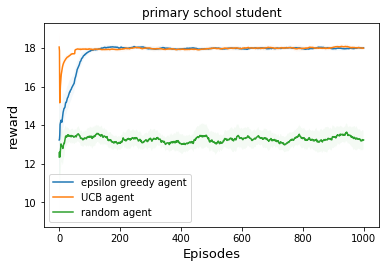

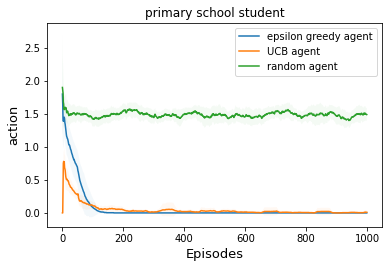

In [ ]:
fig, ax = plt.subplots(figsize = (6, 3.75))
plot_results(rewards_eg,50,fig,ax,'epsilon greedy agent','reward')
plot_results(rewards_UCB,50,fig,ax,'UCB agent','reward')
plot_results(rewards_random,50,fig,ax,'random agent','reward')
plt.title('primary school student')
fig1, ax1 = plt.subplots(figsize = (6, 3.75))
plot_results(actions_eg,50,fig1,ax1,'epsilon greedy agent','action')
plot_results(actions_UCB,50,fig1,ax1,'UCB agent','action')
plot_results(actions_random,50,fig1,ax1,'random agent','action')
plt.title('primary school student')


### Highschool Student

In [ ]:
Actions = [Action(GROUP_CLASS),Action(VIDEO),Action(PRIVATE_CLASS),Action(POWERPOINT)]
student = high_school_student()
env = Environment(student,0)
agent_eg = e_greedy_agent(env)
agent_UCB = UCB_agent(env)
agent_random = Random_Agent(env)
rewards_eg,actions_eg = agent_eg.train(Actions,20,1000)
rewards_UCB,actions_UCB = agent_UCB.train(Actions,20,1000)
rewards_random,actions_random = agent_random.train(Actions,20,1000)

Text(0.5, 1.0, 'Highschool student')

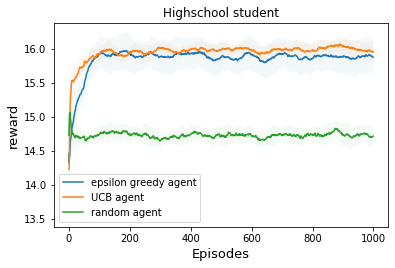

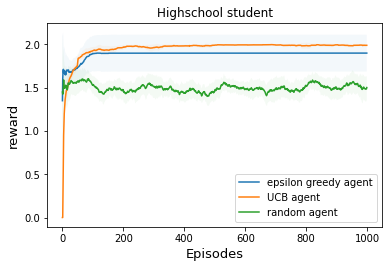

In [ ]:
fig, ax = plt.subplots(figsize = (6, 3.75))
plot_results(rewards_eg,50,fig,ax,'epsilon greedy agent','reward')
plot_results(rewards_UCB,50,fig,ax,'UCB agent','reward')
plot_results(rewards_random,50,fig,ax,'random agent','reward')
plt.title('Highschool student')
fig1, ax1 = plt.subplots(figsize = (6, 3.75))
plot_results(actions_eg,50,fig1,ax1,'epsilon greedy agent','action')
plot_results(actions_UCB,50,fig1,ax1,'UCB agent','action')
plot_results(actions_random,50,fig1,ax1,'random agent','reward')
plt.title('Highschool student')

### University Student

In [ ]:
Actions = [Action(GROUP_CLASS),Action(VIDEO),Action(PRIVATE_CLASS),Action(POWERPOINT)]
student = university_student()
env = Environment(student,0)
agent_eg = e_greedy_agent(env)
agent_UCB = UCB_agent(env)
agent_random = Random_Agent(env)
rewards_eg,actions_eg = agent_eg.train(Actions,20,1000)
rewards_UCB,actions_UCB = agent_UCB.train(Actions,20,1000)
rewards_random,actions_random = agent_random.train(Actions,20,1000)

Text(0.5, 1.0, 'university student')

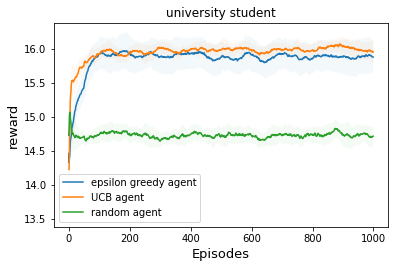

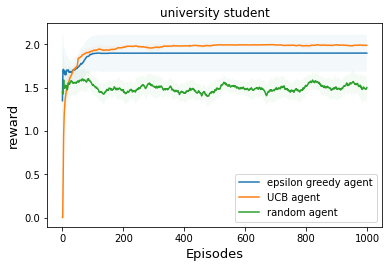

In [ ]:
fig, ax = plt.subplots(figsize = (6, 3.75))
plot_results(rewards_eg,50,fig,ax,'epsilon greedy agent','reward')
plot_results(rewards_UCB,50,fig,ax,'UCB agent','reward')
plot_results(rewards_random,50,fig,ax,'random agent','reward')
plt.title('university student')
fig1, ax1 = plt.subplots(figsize = (6, 3.75))
plot_results(actions_eg,50,fig1,ax1,'epsilon greedy agent','action')
plot_results(actions_UCB,50,fig1,ax1,'UCB agent','action')
plot_results(actions_random,50,fig1,ax1,'random agent','reward')
plt.title('university student')

### Middle Age Learner

In [ ]:
Actions = [Action(GROUP_CLASS),Action(VIDEO),Action(PRIVATE_CLASS),Action(POWERPOINT)]
student = middle_age_learner()
env = Environment(student,0)
agent_eg = e_greedy_agent(env)
agent_UCB = UCB_agent(env)
agent_random = Random_Agent(env)
rewards_eg,actions_eg = agent_eg.train(Actions,20,1000)
rewards_UCB,actions_UCB = agent_UCB.train(Actions,20,1000)
rewards_random,actions_random = agent_random.train(Actions,20,1000)

Text(0.5, 1.0, 'middle age learner')

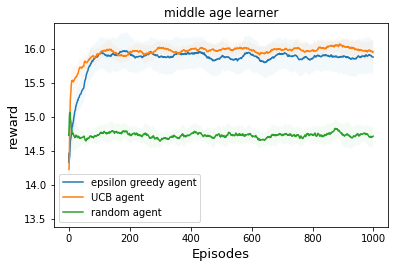

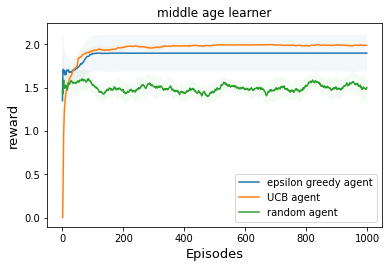

In [ ]:
fig, ax = plt.subplots(figsize = (6, 3.75))
plot_results(rewards_eg,50,fig,ax,'epsilon greedy agent','reward')
plot_results(rewards_UCB,50,fig,ax,'UCB agent','reward')
plot_results(rewards_random,50,fig,ax,'random agent','reward')
plt.title('middle age learner')
fig1, ax1 = plt.subplots(figsize = (6, 3.75))
plot_results(actions_eg,50,fig1,ax1,'epsilon greedy agent','action')
plot_results(actions_UCB,50,fig1,ax1,'UCB agent','action')
plot_results(actions_random,50,fig1,ax1,'random agent','reward')
plt.title('middle age learner')